In [325]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os


In [448]:
#파일 다운로드
train=pd.read_csv("train.csv")
test=pd.read_csv("test.csv")
full_data = [train, test]
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [449]:
#전체적인 info 확인
print (train.info())
print (test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null 

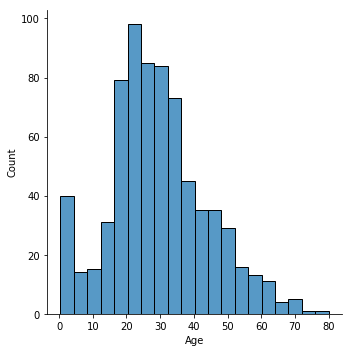

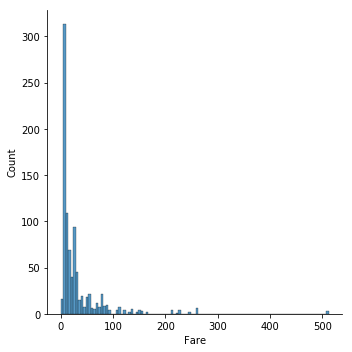

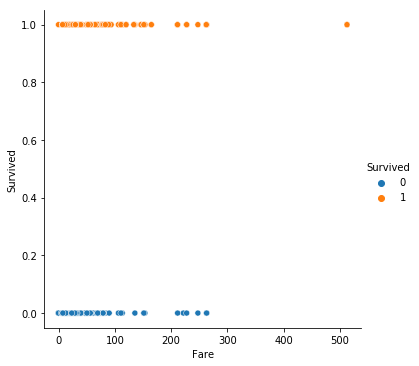

In [450]:
sns.displot(data=train,x='Age')
sns.displot(data=train,x='Fare')
sns.relplot(data=train,x='Fare',y='Survived',hue='Survived')

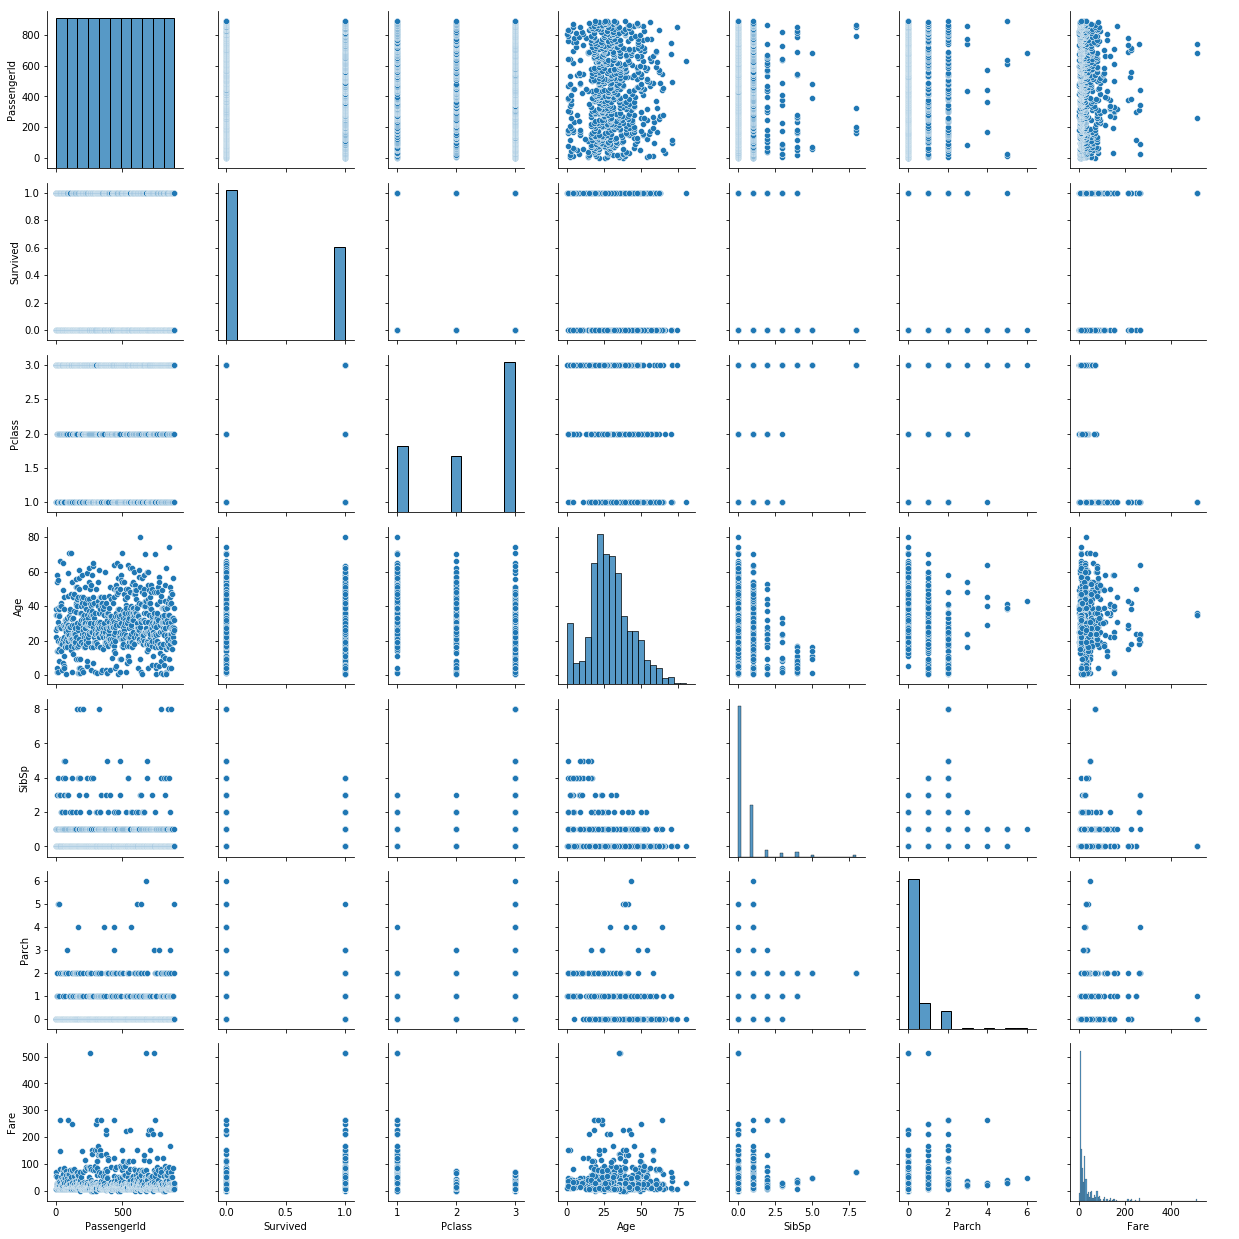

In [451]:
sns.pairplot(train)

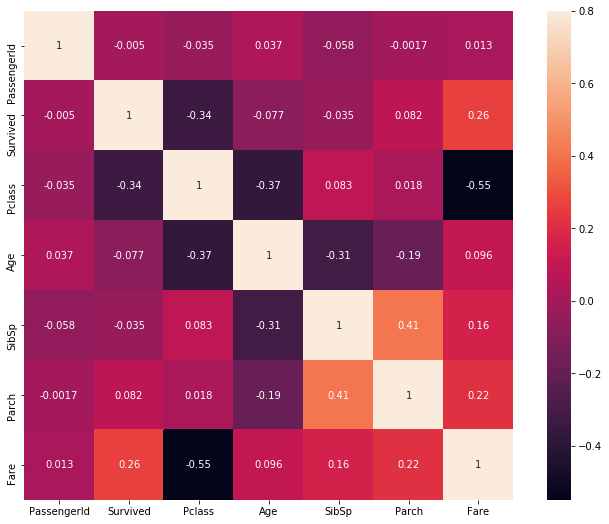

In [452]:
#correlation matrix
corrmat = train.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True,annot=True);

In [453]:
#목적함수 분포확인
train['Survived'].value_counts()

0    549
1    342
Name: Survived, dtype: int64

In [454]:
#class별 생존 확률
print (train[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean())

   Pclass  Survived
0       1  0.629630
1       2  0.472826
2       3  0.242363


In [455]:
#sex별 생존 확률
print (train[["Sex", "Survived"]].groupby(['Sex'], as_index=False).mean())

      Sex  Survived
0  female  0.742038
1    male  0.188908


In [456]:
#Familysize 특성변수 생성
for dataset in full_data:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1
print (train[['FamilySize', 'Survived']].groupby(['FamilySize'], as_index=False).mean())

   FamilySize  Survived
0           1  0.303538
1           2  0.552795
2           3  0.578431
3           4  0.724138
4           5  0.200000
5           6  0.136364
6           7  0.333333
7           8  0.000000
8          11  0.000000


In [457]:
#isalone 특성변수 생성 및 생존확률 
for dataset in full_data:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1
print (train[['IsAlone', 'Survived']].groupby(['IsAlone'], as_index=False).mean())

   IsAlone  Survived
0        0  0.505650
1        1  0.303538


In [458]:
#embarked 결측값 제거하는 코드
train.drop(train[train['Embarked'].isnull()].index,inplace=True)
#embarked 결측값 S로 채우는 코드 
#train['Embarked'].fillna('S',inplace=True)

In [459]:
#embarked - Port of Embarkation (C = Cherbourg; Q = Queenstown; S = Southampton) 별 생존률
print (train[['Embarked', 'Survived']].groupby(['Embarked'], as_index=False).mean())

  Embarked  Survived
0        C  0.553571
1        Q  0.389610
2        S  0.336957


In [460]:
#Fare 채우는 코드 
# from sklearn.impute import SimpleImputer
# imputer = SimpleImputer(strategy = 'median')
# test['Fare']=imputer.fit_transform(test['Fare'].values.reshape(-1,1))
for dataset in full_data:
    dataset['Fare'] = dataset['Fare'].fillna(train['Fare'].median())
train['CategoricalFare'] = pd.qcut(train['Fare'], 4)
print (train[['CategoricalFare', 'Survived']].groupby(['CategoricalFare'], as_index=False).mean())

   CategoricalFare  Survived
0  (-0.001, 7.896]  0.197309
1  (7.896, 14.454]  0.303571
2   (14.454, 31.0]  0.454955
3  (31.0, 512.329]  0.577273


In [461]:
train['CategoricalAge'] = pd.cut(train['Age'], 5)
print (train[['CategoricalAge', 'Survived']].groupby(['CategoricalAge'], as_index=False).mean())

     CategoricalAge  Survived
0    (0.34, 16.336]  0.550000
1  (16.336, 32.252]  0.369942
2  (32.252, 48.168]  0.401070
3  (48.168, 64.084]  0.426471
4    (64.084, 80.0]  0.090909


In [462]:
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""

for dataset in full_data:
    dataset['Title'] = dataset['Name'].apply(get_title)

print(pd.crosstab(train['Title'], train['Sex']))
#pandas 정규표현식 slice
# train['FamilyName']=train['Name'].str.split(r'.',expand=True)[1]
# test['FamilyName']=test['Name'].str.split(r'.',expand=True)[1]
# train['FamilyName']=train['FamilyName'].replace('( )', '', regex=True)
# test['FamilyName']=test['FamilyName'].replace('( )', '', regex=True)
# train['FirstName']=train['Name'].str.split(r'.',expand=True)[0].str.split(r',',expand=True)[0]
# train['Honorific']=train['Name'].str.split(r'.',expand=True)[0].str.split(r',',expand=True)[1]
# test['FirstName']=test['Name'].str.split(r'.',expand=True)[0].str.split(r',',expand=True)[0]
# test['Honorific']=test['Name'].str.split(r'.',expand=True)[0].str.split(r',',expand=True)[1]

Sex       female  male
Title                 
Capt           0     1
Col            0     2
Countess       1     0
Don            0     1
Dr             1     6
Jonkheer       0     1
Lady           1     0
Major          0     2
Master         0    40
Miss         181     0
Mlle           2     0
Mme            1     0
Mr             0   517
Mrs          124     0
Ms             1     0
Rev            0     6
Sir            0     1


In [463]:
for dataset in full_data:
   # dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col',\
    # 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

print (train[['Title', 'Survived']].groupby(['Title'], as_index=False).mean())

       Title  Survived
0       Capt  0.000000
1        Col  0.500000
2   Countess  1.000000
3        Don  0.000000
4         Dr  0.428571
5   Jonkheer  0.000000
6       Lady  1.000000
7      Major  0.500000
8     Master  0.575000
9       Miss  0.701087
10        Mr  0.156673
11       Mrs  0.792000
12       Rev  0.000000
13       Sir  1.000000


In [464]:
print(train.info())
print(test.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 889 entries, 0 to 890
Data columns (total 17 columns):
PassengerId        889 non-null int64
Survived           889 non-null int64
Pclass             889 non-null int64
Name               889 non-null object
Sex                889 non-null object
Age                712 non-null float64
SibSp              889 non-null int64
Parch              889 non-null int64
Ticket             889 non-null object
Fare               889 non-null float64
Cabin              202 non-null object
Embarked           889 non-null object
FamilySize         889 non-null int64
IsAlone            889 non-null int64
CategoricalFare    889 non-null category
CategoricalAge     712 non-null category
Title              889 non-null object
dtypes: category(2), float64(2), int64(7), object(6)
memory usage: 113.0+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 14 columns):
PassengerId    418 non-null int64
Pclass      

In [465]:
y=train['Survived'].values
PassengerId_test=test['PassengerId']
train.drop(['Name', 'Cabin','PassengerId','Ticket','Survived','CategoricalFare','CategoricalAge'], axis=1,inplace=True)
test.drop(['Name', 'Cabin','PassengerId','Ticket'],axis=1,inplace=True)

In [466]:
# #나이 채우는 코드1
# from sklearn.impute import SimpleImputer

# imputer = SimpleImputer(strategy = 'median')
# train['Age']=imputer.fit_transform(train['Age'].values.reshape(-1,1))
# test['Age']=imputer.fit_transform(test['Age'].values.reshape(-1,1))

In [467]:
#나이 채우는 코드2
for dataset in full_data:
    age_avg   = dataset['Age'].mean()
    age_std   = dataset['Age'].std()
    age_null_count = dataset['Age'].isnull().sum()
    
    age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)
    dataset['Age'][np.isnan(dataset['Age'])] = age_null_random_list
    dataset['Age'] = dataset['Age'].astype(int)

C:\Users\Changgwon\AppData\Roaming\Python\Python36\site-packages\ipykernel\__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


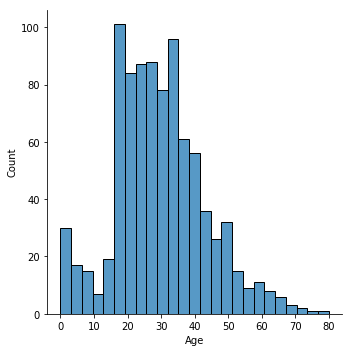

In [468]:
sns.displot(data=train,x='Age')

In [469]:
train[train['Fare']>=200]

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,FamilySize,IsAlone,Title
27,1,male,19,3,2,263.0000,S,6,0,Mr
88,1,female,23,3,2,263.0000,S,6,0,Miss
118,1,male,24,0,1,247.5208,C,2,0,Mr
258,1,female,35,0,0,512.3292,C,1,1,Miss
299,1,female,50,0,1,247.5208,C,2,0,Mrs
311,1,female,18,2,2,262.3750,C,5,0,Miss
341,1,female,24,3,2,263.0000,S,6,0,Miss
377,1,male,27,0,2,211.5000,C,3,0,Mr
380,1,female,42,0,0,227.5250,C,1,1,Miss
438,1,male,64,1,4,263.0000,S,6,0,Mr


In [470]:
train.dtypes

Pclass          int64
Sex            object
Age             int32
SibSp           int64
Parch           int64
Fare          float64
Embarked       object
FamilySize      int64
IsAlone         int64
Title          object
dtype: object

In [471]:
#train['Name'].str.extract(r'(Owen Harris)').isnull().sum()

In [472]:
from sklearn.preprocessing import LabelEncoder
# Create a label encoder object
le = LabelEncoder()
le_count = 0


columns=test.columns
columns
for col in train:
    if train[col].dtype == 'object':
        if len(list(train[col].unique())) <=2:
            le.fit(train[col])
            train[col]=le.transform(train[col])
            test[col]=le.transform(test[col])
            le_count += 1
print('%d columns were label encoded.' % le_count)

1 columns were label encoded.


In [473]:
train = pd.get_dummies(train)
test = pd.get_dummies(test)


In [474]:
train.shape

(889, 25)

In [475]:
test.shape

(418, 19)

In [476]:
train

,Pclass,Sex,Age,SibSp,Parch,Fare,FamilySize,IsAlone,Embarked_C,Embarked_Q,...,Title_Dr,Title_Jonkheer,Title_Lady,Title_Major,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rev,Title_Sir
0,3,1,22,1,0,7.2500,2,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,1,0,38,1,0,71.2833,2,0,1,0,...,0,0,0,0,0,0,0,1,0,0
2,3,0,26,0,0,7.9250,1,1,0,0,...,0,0,0,0,0,1,0,0,0,0
3,1,0,35,1,0,53.1000,2,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,3,1,35,0,0,8.0500,1,1,0,0,...,0,0,0,0,0,0,1,0,0,0
5,3,1,41,0,0,8.4583,1,1,0,1,...,0,0,0,0,0,0,1,0,0,0
6,1,1,54,0,0,51.8625,1,1,0,0,...,0,0,0,0,0,0,1,0,0,0
7,3,1,2,3,1,21.0750,5,0,0,0,...,0,0,0,0,1,0,0,0,0,0
8,3,0,27,0,2,11.1333,3,0,0,0,...,0,0,0,0,0,0,0,1,0,0
9,2,0,14,1,0,30.0708,2,0,1,0,...,0,0,0,0,0,0,0,1,0,0


In [486]:
#column다를 때 맞춰 주는 코드
#y=train['Survived']
train,test = train.align(test, join = 'inner', axis = 1)

C:\Users\Changgwon\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\Changgwon\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\Changgwon\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:740: RuntimeWarning: divide by zero encountered in power
  X2 = np.dot(Xm, R * (S ** (-0.5)))
C:\Users\Changgwon\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:740: RuntimeWarning: invalid value encountered in multiply
  X2 = np.dot(Xm, R * (S ** (-0.5)))
C:\Users\Changgwon\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:743: RuntimeWarning: divide by zero encountered in log
  u = np.asarray([np.sum(np.log(s)) for s in self.scalings_])
C:\

C:\Users\Changgwon\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\Changgwon\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\Changgwon\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:740: RuntimeWarning: divide by zero encountered in power
  X2 = np.dot(Xm, R * (S ** (-0.5)))
C:\Users\Changgwon\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:740: RuntimeWarning: invalid value encountered in multiply
  X2 = np.dot(Xm, R * (S ** (-0.5)))
C:\Users\Changgwon\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:743: RuntimeWarning: divide by zero encountered in log
  u = np.asarray([np.sum(np.log(s)) for s in self.scalings_])
C:\

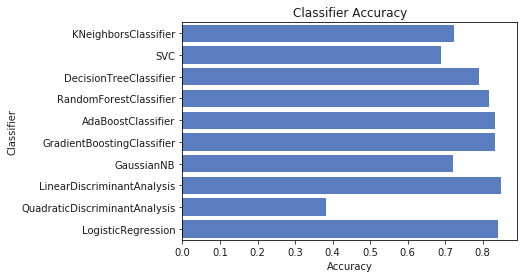

In [489]:
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, log_loss
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression

classifiers = [
    KNeighborsClassifier(3),
    SVC(probability=True),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    GradientBoostingClassifier(),
    GaussianNB(),
    LinearDiscriminantAnalysis(),
    QuadraticDiscriminantAnalysis(),
    LogisticRegression()]

log_cols = ["Classifier", "Accuracy"]
log 	 = pd.DataFrame(columns=log_cols)

sss = StratifiedShuffleSplit(n_splits=10, test_size=0.1, random_state=0)

X = train.values

y

acc_dict = {}

for train_index, test_index in sss.split(X, y):
    
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    for clf in classifiers:
        name = clf.__class__.__name__
        clf.fit(X_train, y_train)
        train_predictions = clf.predict(X_test)
        acc = accuracy_score(y_test, train_predictions)
        if name in acc_dict:
            acc_dict[name] += acc
        else:
            acc_dict[name] = acc

for clf in acc_dict:
    acc_dict[clf] = acc_dict[clf] / 10.0
    log_entry = pd.DataFrame([[clf, acc_dict[clf]]], columns=log_cols)
    log = log.append(log_entry)

plt.xlabel('Accuracy')
plt.title('Classifier Accuracy')

sns.set_color_codes("muted")
sns.barplot(x='Accuracy', y='Classifier', data=log, color="b")

In [430]:
from sklearn.model_selection import train_test_split 
X_train,X_test,y_train,y_test=train_test_split(train ,y, test_size=0.3, random_state=1, stratify=y)

In [436]:
from sklearn.linear_model import LogisticRegression

# Make the model with the specified regularization parameter
log_reg = LogisticRegression(C = 1)

# Train on the training data
log_reg.fit(X_train, y_train)

C:\Users\Changgwon\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1)

In [437]:
y_test_pred=log_reg.predict(X_test)
y_train_pred=log_reg.predict(X_train)
# Accuracy score
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test,y_test_pred))    
print(accuracy_score(y_train,y_train_pred))  
from sklearn.metrics import f1_score
print(f1_score(y_test,y_test_pred))    
print(f1_score(y_train,y_train_pred))
from sklearn.metrics import recall_score
print(recall_score(y_test,y_test_pred)) 
print(recall_score(y_train,y_train_pred))

0.8426966292134831
0.8231511254019293
0.79
0.766949152542373
0.7745098039215687
0.7605042016806722


In [438]:
from sklearn.ensemble import RandomForestClassifier

# Make the random forest classifier
random_forest = RandomForestClassifier()
random_forest.fit(X_train, y_train,)

y_test_pred=random_forest.predict(X_test)
y_train_pred=random_forest.predict(X_train)

from sklearn.metrics import accuracy_score
print(accuracy_score(y_test,y_test_pred))    
print(accuracy_score(y_train,y_train_pred))  
from sklearn.metrics import f1_score
print(f1_score(y_test,y_test_pred))    
print(f1_score(y_train,y_train_pred))
from sklearn.metrics import recall_score
print(recall_score(y_test,y_test_pred)) 
print(recall_score(y_train,y_train_pred))

0.8127340823970037
0.9887459807073955
0.7474747474747475
0.9851380042462844
0.7254901960784313
0.9747899159663865


In [3]:
from sklearn.model_selection import GridSearchCV
depth_range=[1,2,3,4,5,6,7,8,9,10]
n_estimators_range=[5,10,20,30,40,50,60,70,80]
param_grid = [{'max_depth': depth_range, 'n_estimators': n_estimators_range},
              ]
gs = GridSearchCV(estimator=RandomForestClassifier(n_jobs=-1), param_grid=param_grid,
                  scoring='accuracy', cv=5)
gs = gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)

clf = gs.best_estimator_
clf.fit(X_train, y_train)
print(clf.score(X_train,y_train))
clf.score(X_test, y_test)

NameError: name 'RandomForestClassifier' is not defined

In [619]:
random_forest=RandomForestClassifier(max_depth=7,n_estimators=70)
random_forest.fit(train,y)
predictions = random_forest.predict(test)


In [490]:
sample=pd.read_csv("gender_submission.csv")

In [621]:
# Make a submission dataframe
submit = sample[['PassengerId']]
submit['Survived'] = predictions

# Save the submission dataframe
submit.to_csv('submission.csv', index = False)

In [622]:
!kaggle competitions submit -c titanic -f submission.csv -m "Message"


Successfully submitted to Titanic: Machine Learning from Disaster



  0%|          | 0.00/3.18k [00:00<?, ?B/s]
100%|##########| 3.18k/3.18k [00:00<00:00, 15.4kB/s]
100%|##########| 3.18k/3.18k [00:04<00:00, 760B/s]  


In [134]:
from xgboost import XGBClassifier
model = XGBClassifier(subsample=0.9)
model.fit(X_train, y_train)
y_train_pred=model.predict(X_train)
y_test_pred=model.predict(X_test)
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test,y_test_pred))    
print(accuracy_score(y_train,y_train_pred))  
from sklearn.metrics import f1_score
print(f1_score(y_test,y_test_pred))    
print(f1_score(y_train,y_train_pred))
from sklearn.metrics import recall_score
print(recall_score(y_test,y_test_pred)) 
print(recall_score(y_train,y_train_pred))

0.8314606741573034
0.9790996784565916
0.7738693467336684
0.9720430107526882
0.7549019607843137
0.9495798319327731


In [1]:
#max_depth, min_child_weight and gamma.

from sklearn.model_selection import GridSearchCV
depth_range=[1,2,3,4,5,6,7,8,9,10]
min_child_weight=[4,5,6,7,8,9,10]
gamma=[0,0.1,0.01]
subsample=[1,0.9,0.8,0.7]
colsample_bytree=[1,0.9,0.8,0.7]
eta=[0.3,0.2,0.1]
param_grid = [{'max_depth': depth_range, 'min_child_weight': min_child_weight,'gamma':gamma,'subsample':subsample,'colsample_bytree':colsample_bytree,'eta':eta},
              ]
gs = GridSearchCV(estimator=XGBClassifier(verbosity=1), param_grid=param_grid,
                  scoring='accuracy', cv=3,verbose=1)
gs = gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)

clf = gs.best_estimator_
clf.fit(X_train, y_train)
print(clf.score(X_train,y_train))
clf.score(X_test, y_test)

NameError: name 'XGBClassifier' is not defined

In [135]:
xgboost=XGBClassifier(gamma= 0.1, max_depth= 4, min_child_weight= 4,colsample_bytree=0.8,eta=0.3,subsample=0.8)
xgboost.fit(train,y)
predictions = xgboost.predict(test)


In [136]:
sample=pd.read_csv(r"C:\Users\Changgwon\Desktop\하창권\대학원\취업\지원서\CNS\titanic\gender_submission.csv")
# Make a submission dataframe
submit = sample[['PassengerId']]
submit['Survived'] = predictions

# Save the submission dataframe
submit.to_csv('submission.csv', index = False)
!kaggle competitions submit -c titanic -f submission.csv -m "Message"


Successfully submitted to Titanic: Machine Learning from Disaster



  0%|          | 0.00/3.18k [00:00<?, ?B/s]
100%|##########| 3.18k/3.18k [00:00<00:00, 20.7kB/s]
100%|##########| 3.18k/3.18k [00:04<00:00, 780B/s]  


In [247]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train, y, test_size=0.3, random_state=1)

from sklearn.ensemble import RandomForestRegressor
forest=RandomForestRegressor(max_depth=10,n_estimators=70, criterion='mse', random_state=1)
forest.fit(X_train, y_train)
y_train_pred=np.expm1(forest.predict(X_train))
y_test_pred=np.expm1(forest.predict(X_test))

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_log_error
print('RMSE train : %0.3f, test: %0.3f' %(np.sqrt(mean_squared_log_error(np.expm1(y_train), y_train_pred)), np.sqrt(mean_squared_log_error(np.expm1(y_test), y_test_pred))))
print('R**2 train : %0.3f, test: %0.3f' %(r2_score(np.expm1(y_train), y_train_pred), r2_score(np.expm1(y_test), y_test_pred)))

RMSE train : 0.059, test: 0.149
R**2 train : 0.977, test: 0.870


In [238]:
from sklearn.model_selection import GridSearchCV
depth_range=[8,9,10,11,12,13]
n_estimators_range=[50,60,70,80,90,100,110,120]
param_grid = [{ 'n_estimators': n_estimators_range},
              ]
gs = GridSearchCV(estimator=RandomForestRegressor(n_jobs=-1,criterion='mse'), param_grid=param_grid,
                  scoring='neg_mean_squared_error', cv=5)
gs = gs.fit(X_train, y_train)
print(-gs.best_score_)
print(gs.best_params_)

clf = gs.best_estimator_
clf.fit(X_train, y_train)
print(clf.score(X_train,y_train))
clf.score(X_test, y_test)

0.020571883900705242
{'n_estimators': 90}
0.9823907720217102


0.8632739332699517

In [349]:
# import sklearn
# sorted(sklearn.metrics.SCORERS.keys())

In [197]:
forest=RandomForestRegressor(n_estimators=110, criterion='mse', random_state=1)
forest.fit(train, y)
predictions=np.expm1(forest.predict(test))

In [198]:
sample=pd.read_csv(r"C:\Users\Changgwon\Desktop\하창권\대학원\취업\지원서\CNS\house-prices-advanced-regression-techniques\sample_submission.csv")
# Make a submission dataframe
submit = sample[['Id']]
submit['SalePrice'] = predictions

# Save the submission dataframe
submit.to_csv('submission.csv', index = False)
!kaggle competitions submit -c house-prices-advanced-regression-techniques -f submission.csv -m "로그변환, n_est50"



Successfully submitted to House Prices: Advanced Regression Techniques



  0%|          | 0.00/35.1k [00:00<?, ?B/s]
 23%|##2       | 8.00k/35.1k [00:00<00:00, 48.9kB/s]
100%|##########| 35.1k/35.1k [00:07<00:00, 5.10kB/s]
